# Edict Similarity Analysis with SIKU-BERT

This notebook analyzes edicts of a specified type from the extracted_edicts_punc.csv file by creating embedd}ings using SIKU-BERT and comparing their content similarity.

## 0. Setup

Configure proxy settings and install required packages.

In [1]:
!pip install pandas numpy torch transformers scikit-learn matplotlib seaborn tqdm scipy accelerate

## 1. Import Required Libraries

Import the necessary libraries, including pandas for data manipulation, transformers for SIKU-BERT, and matplotlib/seaborn for visualization.

In [2]:
# Import Required Libraries
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from tqdm import tqdm

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
plt.rcParams['figure.figsize'] = (12, 10)

# Configure Chinese font support for all platforms
print("Configuring Chinese font support...")
available_fonts = [f.name for f in fm.fontManager.ttflist]

# Comprehensive list of Chinese fonts for different platforms
# Windows: SimHei, Microsoft YaHei, SimSun
# Mac: PingFang SC, Heiti SC, STHeiti
# Linux: WenQuanYi, Noto Sans CJK, Droid Sans Fallback
# Colab/Cloud: Noto Sans CJK SC (pre-installed)
chinese_fonts = [
    'Noto Sans CJK SC', 'Noto Sans CJK TC', 'Noto Sans SC',  # Cloud/Linux priority
    'PingFang SC', 'Heiti SC', 'STHeiti',  # Mac
    'Microsoft YaHei', 'SimHei', 'SimSun',  # Windows
    'WenQuanYi Micro Hei', 'WenQuanYi Zen Hei',  # Linux
    'Droid Sans Fallback', 'AR PL UMing CN'
]

selected_font = None
for font in chinese_fonts:
    if font in available_fonts:
        selected_font = font
        print(f"✓ Found Chinese font: {selected_font}")
        break

if selected_font is None:
    print("⚠ No Chinese font found. Chinese characters may not display correctly.")
    print("  On Colab, run: !apt-get install -y fonts-noto-cjk")
    print("  On Linux, run: sudo apt-get install fonts-noto-cjk")
    print("  On Mac/Windows, Chinese fonts should be pre-installed.")
    selected_font = 'DejaVu Sans'  # Fallback
else:
    # Configure matplotlib to use the selected font globally
    plt.rcParams['font.sans-serif'] = [selected_font, 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False  # Fix minus sign display
    print(f"✓ Matplotlib configured to use: {selected_font}")

print("Libraries imported successfully!")

/home/yegor/anaconda3/envs/tang_edicts/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuring Chinese font support...
✓ Found Chinese font: Noto Sans CJK SC
✓ Matplotlib configured to use: Noto Sans CJK SC
Libraries imported successfully!


## 2. Load SIKU-BERT Model

Load the SIKU-BERT model and tokenizer from a local directory.

In [3]:
# Model configuration - using local model directory
model_id = "sikubert"

print("Loading SIKU-BERT tokenizer and model from local directory...")
tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    trust_remote_code=True,
    local_files_only=True
)

print("Loading SIKU-BERT model...")
model = AutoModel.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True,
    output_attentions=True,  # Enable attention output for token weighting
    local_files_only=True
)

model.eval()  # Set to evaluation mode
print("SIKU-BERT model loaded successfully!")
print(f"Model device: {model.device}")

Loading SIKU-BERT tokenizer and model from local directory...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading SIKU-BERT model...
SIKU-BERT model loaded successfully!
Model device: cpu


## 3. Define Embedding Function

Create a function to generate embeddings using SIKU-BERT with mean pooling.

In [4]:
def get_embedding(text, pooling='mean'):
    """
    Generate embedding for text using SIKU-BERT.
    
    Args:
        text: Input text to embed
        pooling: Pooling strategy ('mean', 'max', 'cls')
    
    Returns:
        Numpy array of embedding
    """
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", padding=True, 
                      truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Get embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state
    
    # Apply pooling
    if pooling == 'mean':
        # Mean pooling
        attention_mask = inputs['attention_mask'].unsqueeze(-1)
        masked_embeddings = embeddings * attention_mask
        sum_embeddings = masked_embeddings.sum(dim=1)
        sum_mask = attention_mask.sum(dim=1)
        pooled = sum_embeddings / sum_mask
    elif pooling == 'max':
        # Max pooling
        pooled = torch.max(embeddings, dim=1)[0]
    else:  # 'cls'
        # Use [CLS] token
        pooled = embeddings[:, 0, :]
    
    return pooled.cpu().numpy()[0]

print("Embedding function defined.")

Embedding function defined.


## 4. Load and Filter the Data

Load the CSV file extracted_edicts_punctuated.csv using pandas.

In [5]:
# Load the CSV file
df = pd.read_csv('extracted_edicts_punc.csv', encoding='utf-8-sig')

# Display basic information about the dataset
print(f"Total rows in dataset: {len(df)}")
print(f"\nColumn names: {df.columns.tolist()}")

# Display unique document types
if 'document_type' in df.columns:
    unique_types = df['document_type'].unique()
    print(f"\nUnique document types ({len(unique_types)}):")
    for doc_type in sorted(unique_types):
        count = len(df[df['document_type'] == doc_type])
        print(f"  - {doc_type}: {count} documents")
else:
    print("\nNo document_type column found")

Total rows in dataset: 1612

Column names: ['social_category', 'document_type', 'sequence_number', 'text_title', 'author_name', 'text_contents', 'text_contents_punctuated']

Unique document types (145):
  - 九宫貴神: 2 documents
  - 休假: 1 documents
  - 休致: 2 documents
  - 供薦: 2 documents
  - 修復故事: 4 documents
  - 優勞: 8 documents
  - 充奉: 2 documents
  - 冊三公: 7 documents
  - 冊國公: 5 documents
  - 冊尊號赦: 13 documents
  - 冊羣臣: 13 documents
  - 冊贈: 9 documents
  - 册嗣王: 1 documents
  - 册太子赦: 9 documents
  - 册妃: 16 documents
  - 册妃嬪: 3 documents
  - 册文: 56 documents
  - 册親王官: 21 documents
  - 册諡文: 5 documents
  - 册贈: 5 documents
  - 册郡王: 3 documents
  - 出鎮: 23 documents
  - 出降: 2 documents
  - 出降册文: 7 documents
  - 刑法: 18 documents
  - 判使(罷判/): 10 documents
  - 制舉: 23 documents
  - 加冠: 2 documents
  - 加實封: 10 documents
  - 北郊: 1 documents
  - 南郊: 31 documents
  - 即位冊文: 11 documents
  - 即位赦: 13 documents
  - 后土: 3 documents
  - 告廟: 2 documents
  - 命官: 4 documents
  - 命相: 127 documents
  - 和蕃: 5 docu

## 4b. Configure Document Type

Select which document type to analyze. You can change this to any of the types listed above.

In [6]:
# Configure the document type to analyze
DOCUMENT_TYPE = '恩宥'  # Change this to analyze a different document type

# Filter for the selected document type
df_d_type = df[df['document_type'] == DOCUMENT_TYPE].copy()
print(f"\nFiltered for document type: '{DOCUMENT_TYPE}'")
print(f"Number of documents: {len(df_d_type)}")

# Display first few rows
df_d_type.head()


Filtered for document type: '恩宥'
Number of documents: 30


,social_category,document_type,sequence_number,text_title,author_name,text_contents,text_contents_punctuated
1100,政事,恩宥,1,曲赦凉甘等九州制,NaN,朕恭膺寳命綏静氓黎思俾宇内躋於仁夀而河湟之\n表比罹寇賊拘逼凶醜擁隔朝風元元之民匪遑寧晏\n夙興厪慮旰食忘疲重勞師旅不令討擊馭以遐筭且\n事招懐而慕化之徒乗機立効兵不血刅費無遺鏃今\n凶狡即夷...,朕恭膺寳命，綏静氓黎，思俾宇内躋於仁夀。而河湟之表，比罹寇賊，拘逼凶醜，擁隔朝風。元元之民，匪遑寧晏，夙興厪慮，旰食忘疲，重勞師旅，不令討擊，馭以遐筭。且事招懐，而慕化之徒，乗機立効，兵不血刅...
1101,政事,恩宥,2,武德二年十月赦,NaN,朕祗膺靈命君臨區宇承凋弊之餘拯横流之難雖復\n蠲除徭賦督課耕農安集黎元與之休息然而鯨鯢未\n剪四海多虞師旅薦興事不獲已及其士卒浮惰茍求\n逸樂憚於征役離其營伍因此逃竄潛匿﨑嶇竊為生\n資規免朝...,朕祗膺靈命，君臨區宇，承凋弊之餘，拯横流之難。雖復蠲除徭賦，督課耕農，安集黎元，與之休息。然而鯨鯢未剪，四海多虞，師旅薦興，事不獲已。及其士卒浮惰，茍求逸樂，憚於征役，離其營伍，因此逃竄，潛匿...
1102,政事,恩宥,3,益州夔州管内疏理囚徒制,NaN,緩刑議獄哲王彞訓觧網泣辜前賢茂軌朕君臨海内\n撫育黎元一物乖所納隍興慮其益州道行臺及夔州\n總管府衆務臻集統攝遐長囚徒禁繫其數不少或控\n告未申多有寃屈或注引肆意濫及貞良致使文案稽\n延訟獄繁...,緩刑議獄哲王彞訓觧網泣辜前賢茂軌。朕君臨海内，撫育黎元，一物乖所納隍興慮。其益州道行臺及夔州總管府，衆務臻集，統攝遐長，囚徒禁繫，其數不少，或控告未申，多有寃屈；或注引肆意，濫及貞良，致使文案...
1103,政事,恩宥,4,貞觀四年二月大赦,NaN,天生蒸民樹之司牧莫不仰膺靈命克嗣寳圖用能永\n享鴻名常為稱首朕君臨八表於今四載夙興夜寐無\n忘晷刻履薄馭朽思濟黔黎惟此至誠庶㡬王道上荷\n蒼旻之睠下藉股肱之力宇内休平遐邇寧泰率此區\n域致之仁...,天生，蒸民樹之司牧，莫不仰膺靈命，克嗣寳圖，用能，永享鴻名，常為稱首。朕君臨八表，於今四載，夙興夜寐，無忘晷刻，履薄馭朽，思濟黔黎，惟此至誠，庶㡬王道，上荷蒼旻之睠，下藉股肱之力，宇内休平，遐...
1104,政事,恩宥,5,貞觀九年三月大赦,NaN,天地播氣垂生育之德皇王御厯宏覆幬之仁故能財\n成萬𩔖光宅八表朕祗奉慈訓嗣守鴻業承百王之季\n末屬四海之凋殘晨興夕惕無忘兆庶尅已勤躬思隆\n政道欲使隂陽順序干戈載戢庶㡬前烈致兹刑措而\n山東之地...,天地播氣，垂生育之德。皇王御厯，宏覆幬之仁，故能財成萬𩔖，光宅八表。朕祗奉慈訓，嗣守鴻業，承百王之季末，屬四海之凋殘，晨興夕惕，無忘兆。庶尅已勤躬，思隆政道，欲使隂陽順序，干戈載戢，庶㡬前烈，...


## 5. Preprocess the Text Data

Clean and preprocess the text_contents_punctuated column by removing null values and performing any necessary text cleaning.

In [7]:
# Check for null values
print(f"Null values in text_contents_punctuated: {df_d_type['text_contents_punctuated'].isnull().sum()}")

# Remove rows with null text content
df_d_type = df_d_type[df_d_type['text_contents_punctuated'].notna()].copy()

# Remove rows with empty strings
df_d_type = df_d_type[df_d_type['text_contents_punctuated'].str.strip() != ''].copy()

# Reset index
df_d_type.reset_index(drop=True, inplace=True)

print(f"\nNumber of edicts after cleaning: {len(df_d_type)}")

# Display text length statistics
df_d_type['text_length'] = df_d_type['text_contents_punctuated'].str.len()
print(f"\nText length statistics:")
print(df_d_type['text_length'].describe())

# Display sample texts
print("\nSample edict texts:")
for idx, text in enumerate(df_d_type['text_contents_punctuated'].head(3)):
    print(f"\nEdict {idx + 1}: {text[:200]}...")

Null values in text_contents_punctuated: 0

Number of edicts after cleaning: 30

Text length statistics:
count      30.000000
mean      646.233333
std       961.037180
min        78.000000
25%       238.500000
50%       340.500000
75%       507.000000
max      4314.000000
Name: text_length, dtype: float64

Sample edict texts:

Edict 1: 朕恭膺寳命，綏静氓黎，思俾宇内躋於仁夀。而河湟之表，比罹寇賊，拘逼凶醜，擁隔朝風。元元之民，匪遑寧晏，夙興厪慮，旰食忘疲，重勞師旅，不令討擊，馭以遐筭。且事招懐，而慕化之徒，乗機立効，兵不血刅，費無遺。鏃今凶狡即夷西陲，克定逺人悦附，政道惟新，宜播惠澤，與之更始，可曲赦凉。甘。𤓰。鄯。肅。㑹。蘭。河。廓九州，自武德二年五月十六日以前，罪無輕重，已發覺繋囚見徒，並從原免。桀犬吠堯，非無前喻，棄瑕蕩穢...

Edict 2: 朕祗膺靈命，君臨區宇，承凋弊之餘，拯横流之難。雖復蠲除徭賦，督課耕農，安集黎元，與之休息。然而鯨鯢未剪，四海多虞，師旅薦興，事不獲已。及其士卒浮惰，茍求逸樂，憚於征役，離其營伍，因此逃竄，潛匿﨑嶇，竊為生資，規免朝夕良由，勸勵不明，部署失所，踈慢之責，在於朕躬琴瑟不調，已云變革，多墜刑網，兼堪痛悼，宜從寛宥，許以自新。其義士募力，有背軍逃亡者，自武德二年十月二十日以前，罪無輕重，皆赦除之。饑寒困敝...

Edict 3: 緩刑議獄哲王彞訓觧網泣辜前賢茂軌。朕君臨海内，撫育黎元，一物乖所納隍興慮。其益州道行臺及夔州總管府，衆務臻集，統攝遐長，囚徒禁繫，其數不少，或控告未申，多有寃屈；或注引肆意，濫及貞良，致使文案稽延，訟獄繁擁，念彼枉滯，情深愍惻。其益州管内諸州，委御史大夫無逸檢校；夔州管内，委趙郡公孝恭檢校。所有囚徒悉令覆察，務使寛簡，小大以情。但有負罪逃亡離業鄉邑，無問輕重，悉令歸首，明加勸導，務修墾植，庶使家給...


## 6. Generate Text Embeddings with SIKU-BERT

Use SIKU-BERT to convert the text contents into numerical embeddings/vectors.

In [8]:
# Generate embeddings for all edicts
print("Generating embeddings for all edicts using SIKU-BERT...")
print("This may take a few minutes depending on the number of edicts.\n")

embeddings_list = []

for idx, text in enumerate(tqdm(df_d_type['text_contents_punctuated'], desc="Encoding texts")):
    embedding = get_embedding(text, pooling='mean')
    embeddings_list.append(embedding)

# Convert to numpy array
edict_embeddings = np.array(embeddings_list)

print(f"\nEmbedding shape: {edict_embeddings.shape}")
print(f"Number of edicts: {edict_embeddings.shape[0]}")
print(f"Embedding dimension: {edict_embeddings.shape[1]}")

# Save embeddings for later use
np.save(f'{DOCUMENT_TYPE}_embeddings_sikubert.npy', edict_embeddings)
print(f"\nEmbeddings saved to '{DOCUMENT_TYPE}_embeddings_sikubert.npy'")

Generating embeddings for all edicts using SIKU-BERT...
This may take a few minutes depending on the number of edicts.



Encoding texts: 100%|██████████| 30/30 [03:25<00:00,  6.84s/it]


Embedding shape: (30, 768)
Number of edicts: 30
Embedding dimension: 768

Embeddings saved to '恩宥_embeddings_sikubert.npy'


## 7. Calculate Similarity Between Edicts

Compute pairwise cosine similarity between all edict embeddings to measure content similarity.

In [9]:
# Calculate cosine similarity matrix
print("Calculating pairwise cosine similarity...")
similarity_matrix = cosine_similarity(edict_embeddings)

print(f"Similarity matrix shape: {similarity_matrix.shape}")
print(f"\nSimilarity statistics:")
upper_triangle = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]
print(f"Min similarity: {upper_triangle.min():.4f}")
print(f"Max similarity (excluding diagonal): {upper_triangle.max():.4f}")
print(f"Mean similarity: {upper_triangle.mean():.4f}")
print(f"Median similarity: {np.median(upper_triangle):.4f}")
print(f"Std deviation: {upper_triangle.std():.4f}")

# Display a sample of the similarity matrix
print("\nSample of similarity matrix (first 5x5):")
print(pd.DataFrame(similarity_matrix[:5, :5]).round(3))

# Save similarity matrix
np.save(f'{DOCUMENT_TYPE}_similarity_matrix_sikubert.npy', similarity_matrix)
print(f"\nSimilarity matrix saved to '{DOCUMENT_TYPE}_similarity_matrix_sikubert.npy'")

Calculating pairwise cosine similarity...
Similarity matrix shape: (30, 30)

Similarity statistics:
Min similarity: 0.9125
Max similarity (excluding diagonal): 0.9892
Mean similarity: 0.9648
Median similarity: 0.9675
Std deviation: 0.0135

Sample of similarity matrix (first 5x5):
       0      1      2      3      4
0  1.000  0.966  0.952  0.975  0.971
1  0.966  1.000  0.962  0.969  0.973
2  0.952  0.962  1.000  0.947  0.957
3  0.975  0.969  0.947  1.000  0.979
4  0.971  0.973  0.957  0.979  1.000

Similarity matrix saved to '恩宥_similarity_matrix_sikubert.npy'


## 8. Visualize Similarity Matrix

Create a heatmap visualization of the similarity matrix to identify patterns and clusters of similar edicts.

Using font for heatmap: Noto Sans CJK SC


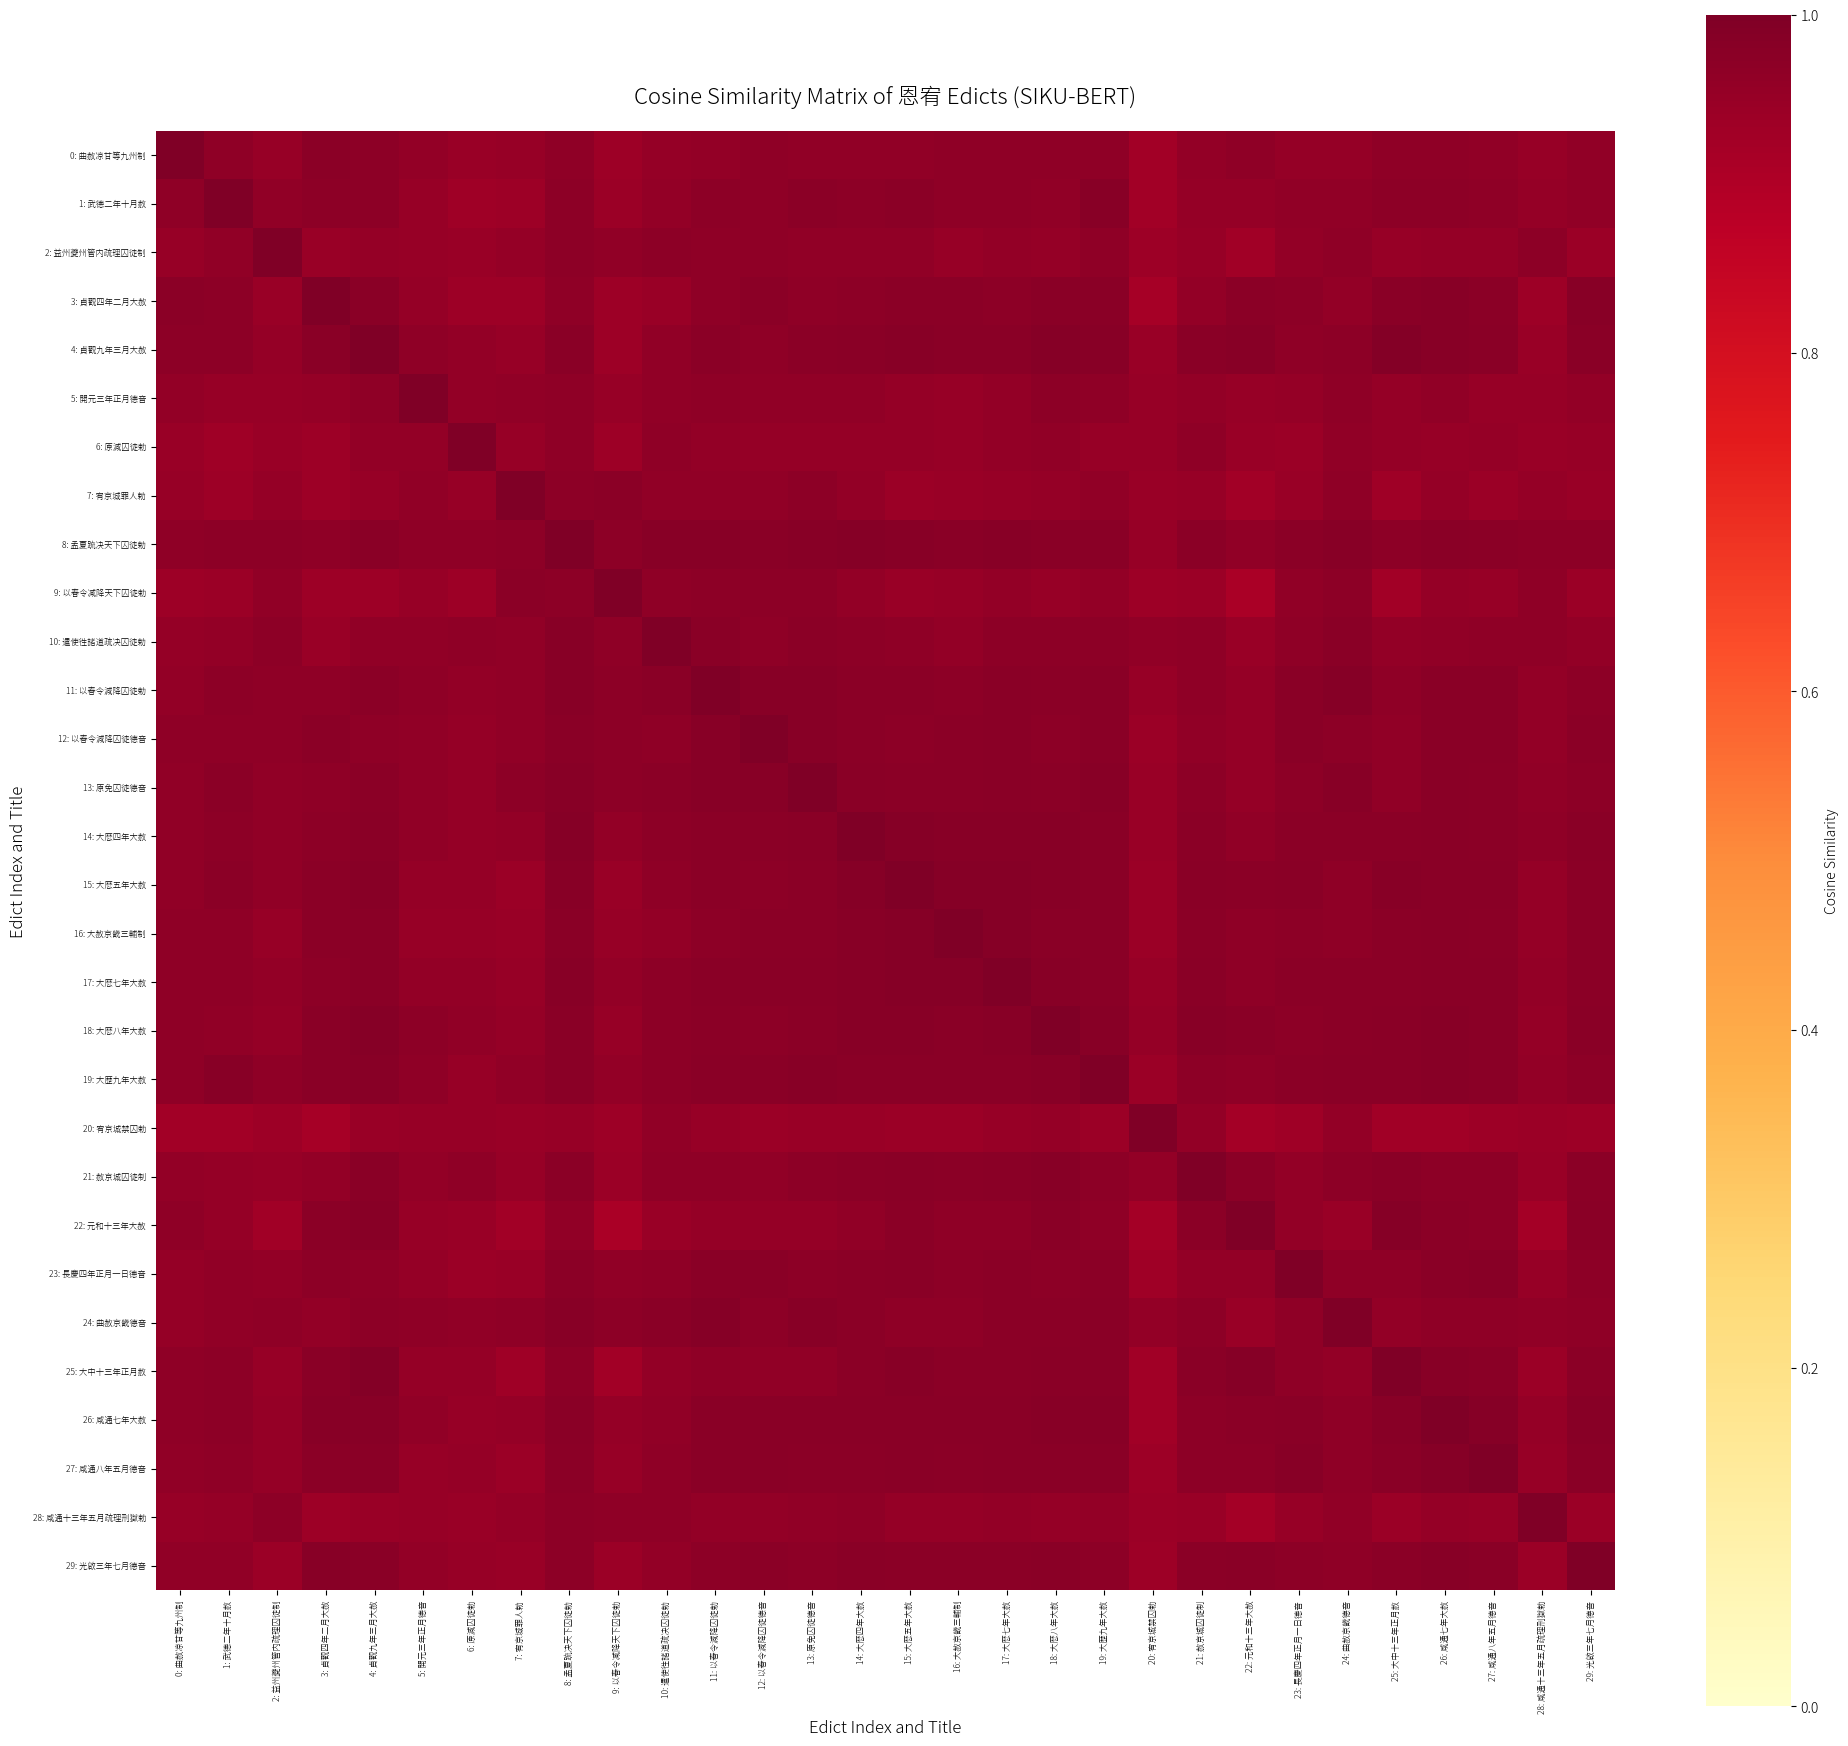

Heatmap saved as 'similarity_heatmap_恩宥_sikubert.png'


In [10]:
# Create heatmap of similarity matrix with edict titles
# Prepare labels - truncate long titles for readability
labels = []
for i in range(len(df_d_type)):
    title = df_d_type.iloc[i]['text_title'] if 'text_title' in df_d_type.columns else f"Edict {i}"
    # Truncate title if too long
    if len(title) > 20:
        title = title[:20] + '...'
    # Add index for clarity
    labels.append(f"{i}: {title}")

# Determine appropriate font size based on number of edicts
n_edicts = len(df_d_type)
if n_edicts <= 20:
    label_font_size = 8
    fig_size = (16, 14)
elif n_edicts <= 50:
    label_font_size = 6
    fig_size = (20, 18)
else:
    label_font_size = 4
    fig_size = (24, 22)

# Ensure Chinese font is being used for this plot
try:
    current_font = plt.rcParams['font.sans-serif'][0]
    print(f"Using font for heatmap: {current_font}")
except:
    print("⚠ Font not configured, Chinese characters may not display correctly")

plt.figure(figsize=fig_size)
sns.heatmap(
    similarity_matrix,
    cmap='YlOrRd',
    vmin=0,
    vmax=1,
    square=True,
    cbar_kws={'label': 'Cosine Similarity'},
    xticklabels=labels,
    yticklabels=labels
)
plt.title(f'Cosine Similarity Matrix of {DOCUMENT_TYPE} Edicts (SIKU-BERT)', fontsize=16, pad=20)
plt.xlabel('Edict Index and Title', fontsize=12)
plt.ylabel('Edict Index and Title', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=label_font_size)
plt.yticks(rotation=0, fontsize=label_font_size)

plt.tight_layout()
plt.savefig(f'similarity_heatmap_{DOCUMENT_TYPE}_sikubert.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Heatmap saved as 'similarity_heatmap_{DOCUMENT_TYPE}_sikubert.png'")

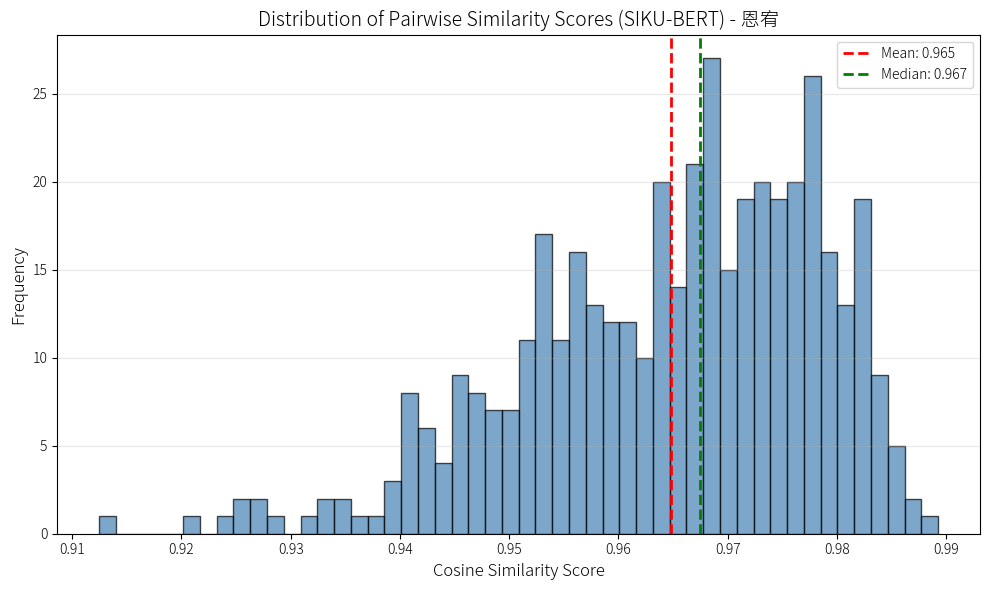

Distribution plot saved as 'similarity_distribution_恩宥_sikubert.png'


In [11]:
# Create a distribution plot of similarity scores
plt.figure(figsize=(10, 6))
similarity_scores = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]
plt.hist(similarity_scores, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
plt.axvline(similarity_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {similarity_scores.mean():.3f}')
plt.axvline(np.median(similarity_scores), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(similarity_scores):.3f}')
plt.xlabel('Cosine Similarity Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Distribution of Pairwise Similarity Scores (SIKU-BERT) - {DOCUMENT_TYPE}', fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f'similarity_distribution_{DOCUMENT_TYPE}_sikubert.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Distribution plot saved as 'similarity_distribution_{DOCUMENT_TYPE}_sikubert.png'")

## 9. Find Most Similar Edicts

For each edict, identify and display the top N most similar edicts based on the similarity scores.

In [12]:
# Function to find top N most similar edicts
def find_most_similar(edict_idx, similarity_matrix, df, top_n=5):
    """
    Find the top N most similar edicts to a given edict.
    
    Parameters:
    - edict_idx: Index of the edict to compare
    - similarity_matrix: Pairwise similarity matrix
    - df: DataFrame containing edict information
    - top_n: Number of similar edicts to return
    
    Returns:
    - DataFrame with most similar edicts
    """
    # Get similarity scores for the given edict
    similarities = similarity_matrix[edict_idx]
    
    # Get indices of top N similar edicts (excluding itself)
    similar_indices = np.argsort(similarities)[::-1][1:top_n+1]
    
    # Create results DataFrame
    results = []
    for rank, idx in enumerate(similar_indices, 1):
        results.append({
            'Rank': rank,
            'Index': idx,
            'Similarity': similarities[idx],
            'Title': df.iloc[idx]['text_title'] if 'text_title' in df.columns else f"Edict {idx}",
            'Text_Preview': df.iloc[idx]['text_contents_punctuated'][:100] + '...'
        })
    
    return pd.DataFrame(results)

# Example: Find most similar edicts for the first 3 edicts
print("=" * 100)
for i in range(min(3, len(df_d_type))):
    print(f"\n{'='*100}")
    title = df_d_type.iloc[i]['text_title'] if 'text_title' in df_d_type.columns else f"Edict {i}"
    print(f"EDICT #{i} - {title}")
    print(f"Original Text:")
    print(f"{df_d_type.iloc[i]['text_contents_punctuated'][:200]}...")
    print(f"\n{'-'*100}")
    print(f"Top 5 Most Similar Edicts:")
    print(f"{'-'*100}")
    
    similar_edicts = find_most_similar(i, similarity_matrix, df_d_type, top_n=5)
    
    for _, row in similar_edicts.iterrows():
        print(f"\nRank {row['Rank']} - {row['Title']} (Similarity: {row['Similarity']:.4f}):")
        print(f"  {row['Text_Preview']}")
    
    print(f"\n{'='*100}")


EDICT #0 - 曲赦凉甘等九州制
Original Text:
朕恭膺寳命，綏静氓黎，思俾宇内躋於仁夀。而河湟之表，比罹寇賊，拘逼凶醜，擁隔朝風。元元之民，匪遑寧晏，夙興厪慮，旰食忘疲，重勞師旅，不令討擊，馭以遐筭。且事招懐，而慕化之徒，乗機立効，兵不血刅，費無遺。鏃今凶狡即夷西陲，克定逺人悦附，政道惟新，宜播惠澤，與之更始，可曲赦凉。甘。𤓰。鄯。肅。㑹。蘭。河。廓九州，自武德二年五月十六日以前，罪無輕重，已發覺繋囚見徒，並從原免。桀犬吠堯，非無前喻，棄瑕蕩穢...

----------------------------------------------------------------------------------------------------
Top 5 Most Similar Edicts:
----------------------------------------------------------------------------------------------------

Rank 1 - 貞觀四年二月大赦 (Similarity: 0.9752):
  天生，蒸民樹之司牧，莫不仰膺靈命，克嗣寳圖，用能，永享鴻名，常為稱首。朕君臨八表，於今四載，夙興夜寐，無忘晷刻，履薄馭朽，思濟黔黎，惟此至誠，庶㡬王道，上荷蒼旻之睠，下藉股肱之力，宇内休平，遐邇寧泰。...

Rank 2 - 貞觀九年三月大赦 (Similarity: 0.9712):
  天地播氣，垂生育之德。皇王御厯，宏覆幬之仁，故能財成萬𩔖，光宅八表。朕祗奉慈訓，嗣守鴻業，承百王之季末，屬四海之凋殘，晨興夕惕，無忘兆。庶尅已勤躬，思隆政道，欲使隂陽順序，干戈載戢，庶㡬前烈，致兹刑措...

Rank 3 - 元和十三年大赦 (Similarity: 0.9687):
  朕聞王者法天作，則與衆守邦，奉天無私，居兆人上，當恭已嚮方之際，切臨深馭朽之懷，憂勤靡遑，今古何逺！所重者兵革不試，軌度自貞，熈仁育和，以至大道。朕顧惟菲德，祗奉睿圖，承昊天之眷命，纘列聖之丕緒，昃食...

Rank 4 - 大中十三年正月赦 (Similarity: 0.9686):
  天將發生，萬物也，則必假以暄妍，潤以風雨。王者之在，宥四海也，期必滌其瑕穢，施以渥恩，固頻啟於

## 10. Edict Similarity Summary Statistics

Calculate and display summary statistics for each edict's similarity to all other edicts.

In [13]:
# Create a summary DataFrame with similarity statistics for each edict
summary_data = []

for i in range(len(df_d_type)):
    similarities = similarity_matrix[i]
    # Exclude self-similarity (diagonal)
    other_similarities = np.concatenate([similarities[:i], similarities[i+1:]])
    
    title = df_d_type.iloc[i]['text_title'] if 'text_title' in df_d_type.columns else f"Edict {i}"
    
    summary_data.append({
        'Edict_Index': i,
        'Title': title,
        'Text_Length': df_d_type.iloc[i]['text_length'],
        'Text_Preview': df_d_type.iloc[i]['text_contents_punctuated'][:80] + '...',
        'Avg_Similarity': other_similarities.mean(),
        'Max_Similarity': other_similarities.max(),
        'Min_Similarity': other_similarities.min(),
        'Std_Similarity': other_similarities.std()
    })

summary_df = pd.DataFrame(summary_data)
# Set Edict_Index as the index to avoid duplicate numbering
summary_df.set_index('Edict_Index', inplace=True)

print("\nEdicts Ranked by Average Similarity to Other Edicts:")
print("="*100)
summary_df.sort_values('Avg_Similarity', ascending=False).head(10)


Edicts Ranked by Average Similarity to Other Edicts:


,Title,Text_Length,Text_Preview,Avg_Similarity,Max_Similarity,Min_Similarity,Std_Similarity
Edict_Index,,,,,,,
8,孟夏䟽决天下囚徒勅,313,法以閑邪，刑以助化，因時而制，葢非獲已。朕自臨御天下，憂勞庶務以至誠感物道，冀有孚以至理致和，仁或由已，豈欲以刑制政，期於以化清刑，故不用殊絶之誅。毎施寛大之令...,0.974487,0.985587,0.952707,0.007577
19,大歴九年大赦,405,朕誕膺天命，以撫方夏，夙夜兢惕，保祐惟人懼庶獄之未孚，俾一夫之不獲，思用哀恤，與之和寧。頃屬夷夏，多虞，干戈是務，徴賦頗重，黎元不康，内廹艱窮，外乘師旅，因行盗...,0.972715,0.982977,0.944798,0.009597
18,大厯八年大赦,419,自古帝王順時行令，當此時之炎燠，應南風之長嬴，必事無刑，觧網申惠，叙麥秋之氣，而代天理物矣。朕獲奉珪璧，䖍恭郊廟，二紀有餘，承累聖之鴻業，為兆人之父母，戰戰兢兢...,0.972546,0.986491,0.953042,0.009859
14,大厯四年大赦,483,勅至理之代，先德後刑，上歡心以臨下，下欣然而奉上禍亂不作，法令何施。去聖久逺，薄於教化，簡書填委，獄訟繁興，苛吏舞文，寃人致辟，思欲刷恥改行，厥路無由，豈天地父...,0.972255,0.986769,0.946666,0.009350
17,大厯七年大赦,568,門下。濟於道者，化醇而刑措，善於理者，綱舉而網踈。朕渉道未宏，燭理多昧，常亦遐想太古，髙挹𤣥風，保合太和，在宥天下，葢德薄而未臻也。是用因時以設教，便俗以立功，...,0.971777,0.985899,0.949237,0.010223
11,以春令減降囚徒勅,368,國之用刑，兼在於慎恤，王者布澤，亦在於乘時。所以大易陳規，必議於獄。周官設教，遵於中典。朕恭臨寳位，憂念黎元乾乾之心，日慎一日。况兵戎未息，政役尤煩，哀此下人無...,0.971341,0.984497,0.952602,0.008868
26,咸通七年大赦,4314,我國家膺天明命，光宅萬方，二百有五十載矣。梯航所及，昭顯於夏殷，文軌攸同，夐逾於漢晉。朕承十六聖之業，居億兆人之上。猥惟𦕈身，祗荷丕構，逺奉貞觀開元之至理，近宗...,0.971151,0.984750,0.933216,0.012343
13,原免囚徒德音,295,元首之義，以人為心，外有凋傷，内懐惨怛，罪歸於已，情見乎辭。伯禹深泣辜之仁。漢王下哀痛之詔，與理同道，惟刑是恤。朕志宏覆載，運屬艱難，思措大刑，俾登夀域，風以觧...,0.971021,0.983850,0.946980,0.008920
4,貞觀九年三月大赦,301,天地播氣，垂生育之德。皇王御厯，宏覆幬之仁，故能財成萬𩔖，光宅八表。朕祗奉慈訓，嗣守鴻業，承百王之季末，屬四海之凋殘，晨興夕惕，無忘兆。庶尅已勤躬，思隆政道，欲...,0.970936,0.989244,0.940632,0.012379


## 10b. Identify Highly Similar Pairs

Find pairs of edicts with similarity scores above a specified threshold.

In [14]:
# Identify pairs of highly similar edicts
# Start with a high threshold and provide statistics to guide adjustment
threshold = 0.98  # Adjust this threshold as needed (try 0.9, 0.95, or 0.98)

print(f"Pairs of edicts with similarity >= {threshold}:")
print("="*100)

high_similarity_pairs = []
for i in range(len(similarity_matrix)):
    for j in range(i+1, len(similarity_matrix)):
        if similarity_matrix[i, j] >= threshold:
            title_1 = df_d_type.iloc[i]['text_title'] if 'text_title' in df_d_type.columns else f"Edict {i}"
            title_2 = df_d_type.iloc[j]['text_title'] if 'text_title' in df_d_type.columns else f"Edict {j}"
            
            high_similarity_pairs.append({
                'Edict_1_Index': i,
                'Edict_1_Title': title_1,
                'Edict_2_Index': j,
                'Edict_2_Title': title_2,
                'Similarity': similarity_matrix[i, j],
                'Text_1_Preview': df_d_type.iloc[i]['text_contents_punctuated'][:80] + '...',
                'Text_2_Preview': df_d_type.iloc[j]['text_contents_punctuated'][:80] + '...'
            })

if high_similarity_pairs:
    pairs_df = pd.DataFrame(high_similarity_pairs)
    pairs_df = pairs_df.sort_values('Similarity', ascending=False)
    # Reset index to show Pair_Number starting from 1
    pairs_df.reset_index(drop=True, inplace=True)
    pairs_df.index = pairs_df.index + 1
    pairs_df.index.name = 'Pair_Number'
    
    print(f"\nFound {len(pairs_df)} pairs with similarity >= {threshold}")
    
    # Show threshold guidance
    print("\n" + "="*100)
    print("Threshold Guidance:")
    print("="*100)
    for test_threshold in [0.99, 0.95, 0.90, 0.85, 0.80]:
        count = len([1 for i in range(len(similarity_matrix)) 
                     for j in range(i+1, len(similarity_matrix)) 
                     if similarity_matrix[i, j] >= test_threshold])
        print(f"  Threshold {test_threshold}: {count} pairs")
    print("\nRecommendation: Use a threshold that gives 10-100 pairs for meaningful analysis")
    print("="*100 + "\n")
    
    # Save to CSV for further analysis
    pairs_df.to_csv(f'similar_pairs_{DOCUMENT_TYPE}_threshold_{threshold}.csv', 
                    encoding='utf-8-sig')
    print(f"Pairs saved to 'similar_pairs_{DOCUMENT_TYPE}_threshold_{threshold}.csv'\n")
    
    # Display the results
    print(f"Displaying top 20 most similar pairs:")
    display(pairs_df.head(20))
    
    # Return the full dataframe for further inspection
    pairs_df
else:
    print(f"\nNo pairs found with similarity >= {threshold}")
    print("Consider lowering the threshold to find similar pairs.")
    print(f"\nTry thresholds between {upper_triangle.mean():.3f} (mean) and {upper_triangle.max():.3f} (max)")

Pairs of edicts with similarity >= 0.98:

Found 49 pairs with similarity >= 0.98

Threshold Guidance:
  Threshold 0.99: 0 pairs
  Threshold 0.95: 371 pairs
  Threshold 0.9: 435 pairs
  Threshold 0.85: 435 pairs
  Threshold 0.8: 435 pairs

Recommendation: Use a threshold that gives 10-100 pairs for meaningful analysis

Pairs saved to 'similar_pairs_恩宥_threshold_0.98.csv'

Displaying top 20 most similar pairs:


,Edict_1_Index,Edict_1_Title,Edict_2_Index,Edict_2_Title,Similarity,Text_1_Preview,Text_2_Preview
Pair_Number,,,,,,,
1,4,貞觀九年三月大赦,25,大中十三年正月赦,0.989244,天地播氣，垂生育之德。皇王御厯，宏覆幬之仁，故能財成萬𩔖，光宅八表。朕祗奉慈訓，嗣守鴻業，承百王之季末，屬四海之凋殘，晨興夕惕，無忘兆。庶尅已勤躬，思隆政道，欲...,天將發生，萬物也，則必假以暄妍，潤以風雨。王者之在，宥四海也，期必滌其瑕穢，施以渥恩，固頻啟於倖門，豈無彰於皇澤！朕以菲德，獲纘丕圖，常慕唐堯之無為，漢文之恭儉...
2,14,大厯四年大赦,15,大厯五年大赦,0.986769,勅至理之代，先德後刑，上歡心以臨下，下欣然而奉上禍亂不作，法令何施。去聖久逺，薄於教化，簡書填委，獄訟繁興，苛吏舞文，寃人致辟，思欲刷恥改行，厥路無由，豈天地父...,門下，惟辟奉天作人父母。若天垂戒於上，人不安於下，則修德勤政，以盡至誠，恤刑獄之寃，抑痛閭閻之疾苦，招納諌諍，旁求賢良，允廸前烈，率由兹道。朕獲承宗廟之重，託於...
3,4,貞觀九年三月大赦,18,大厯八年大赦,0.986491,天地播氣，垂生育之德。皇王御厯，宏覆幬之仁，故能財成萬𩔖，光宅八表。朕祗奉慈訓，嗣守鴻業，承百王之季末，屬四海之凋殘，晨興夕惕，無忘兆。庶尅已勤躬，思隆政道，欲...,自古帝王順時行令，當此時之炎燠，應南風之長嬴，必事無刑，觧網申惠，叙麥秋之氣，而代天理物矣。朕獲奉珪璧，䖍恭郊廟，二紀有餘，承累聖之鴻業，為兆人之父母，戰戰兢兢...
4,15,大厯五年大赦,17,大厯七年大赦,0.985899,門下，惟辟奉天作人父母。若天垂戒於上，人不安於下，則修德勤政，以盡至誠，恤刑獄之寃，抑痛閭閻之疾苦，招納諌諍，旁求賢良，允廸前烈，率由兹道。朕獲承宗廟之重，託於...,門下。濟於道者，化醇而刑措，善於理者，綱舉而網踈。朕渉道未宏，燭理多昧，常亦遐想太古，髙挹𤣥風，保合太和，在宥天下，葢德薄而未臻也。是用因時以設教，便俗以立功，...
5,22,元和十三年大赦,25,大中十三年正月赦,0.985618,朕聞王者法天作，則與衆守邦，奉天無私，居兆人上，當恭已嚮方之際，切臨深馭朽之懷，憂勤靡遑，今古何逺！所重者兵革不試，軌度自貞，熈仁育和，以至大道。朕顧惟菲德，祗...,天將發生，萬物也，則必假以暄妍，潤以風雨。王者之在，宥四海也，期必滌其瑕穢，施以渥恩，固頻啟於倖門，豈無彰於皇澤！朕以菲德，獲纘丕圖，常慕唐堯之無為，漢文之恭儉...
6,8,孟夏䟽决天下囚徒勅,14,大厯四年大赦,0.985587,法以閑邪，刑以助化，因時而制，葢非獲已。朕自臨御天下，憂勞庶務以至誠感物道，冀有孚以至理致和，仁或由已，豈欲以刑制政，期於以化清刑，故不用殊絶之誅。毎施寛大之令...,勅至理之代，先德後刑，上歡心以臨下，下欣然而奉上禍亂不作，法令何施。去聖久逺，薄於教化，簡書填委，獄訟繁興，苛吏舞文，寃人致辟，思欲刷恥改行，厥路無由，豈天地父...
7,15,大厯五年大赦,16,大赦京畿三輔制,0.984848,門下，惟辟奉天作人父母。若天垂戒於上，人不安於下，則修德勤政，以盡至誠，恤刑獄之寃，抑痛閭閻之疾苦，招納諌諍，旁求賢良，允廸前烈，率由兹道。朕獲承宗廟之重，託於...,門下。古者以春季之月，布德行惠，恤刑振乏，朕親執犧牲玉帛，獲奉於上帝，神祗九年於兹矣。克已思理，明不能燭，昆夷未叙，王畧猶虞嵗㑹。三秦之師，日有千金之費，悉索幣...
8,26,咸通七年大赦,27,咸通八年五月德音,0.984750,我國家膺天明命，光宅萬方，二百有五十載矣。梯航所及，昭顯於夏殷，文軌攸同，夐逾於漢晉。朕承十六聖之業，居億兆人之上。猥惟𦕈身，祗荷丕構，逺奉貞觀開元之至理，近宗...,朕聞唯天為大，唯堯則之施。及文王，昭事上帝，朕退思古訓，順考前聞，仰止於皇王之間，規範於堯文之際，始如徒渉而望超溟渤，中若䇿蹇而求躡雲霄，思逮於三希之則至。由是...
9,11,以春令減降囚徒勅,24,曲赦京畿德音,0.984497,國之用刑，兼在於慎恤，王者布澤，亦在於乘時。所以大易陳規，必議於獄。周官設教，遵於中典。朕恭臨寳位，憂念黎元乾乾之心，日慎一日。况兵戎未息，政役尤煩，哀此下人無...,王者愛人如身，推己及物，恤其寒燠之苦，適其舒惨之宜。俾叶太和用臻至理，恭黙思道，憂勤在懐，時屬嚴沴，念深徽纆，當霜雪之候，滯囹圄之中，饋餉為勞，逮捕斯擾，沍寒所...


## 11. Cluster Analysis 

Perform hierarchical clustering to identify groups of similar edicts.

Using configured Chinese font for dendrogram...
✓ Current font: Noto Sans CJK SC
Performing hierarchical clustering...


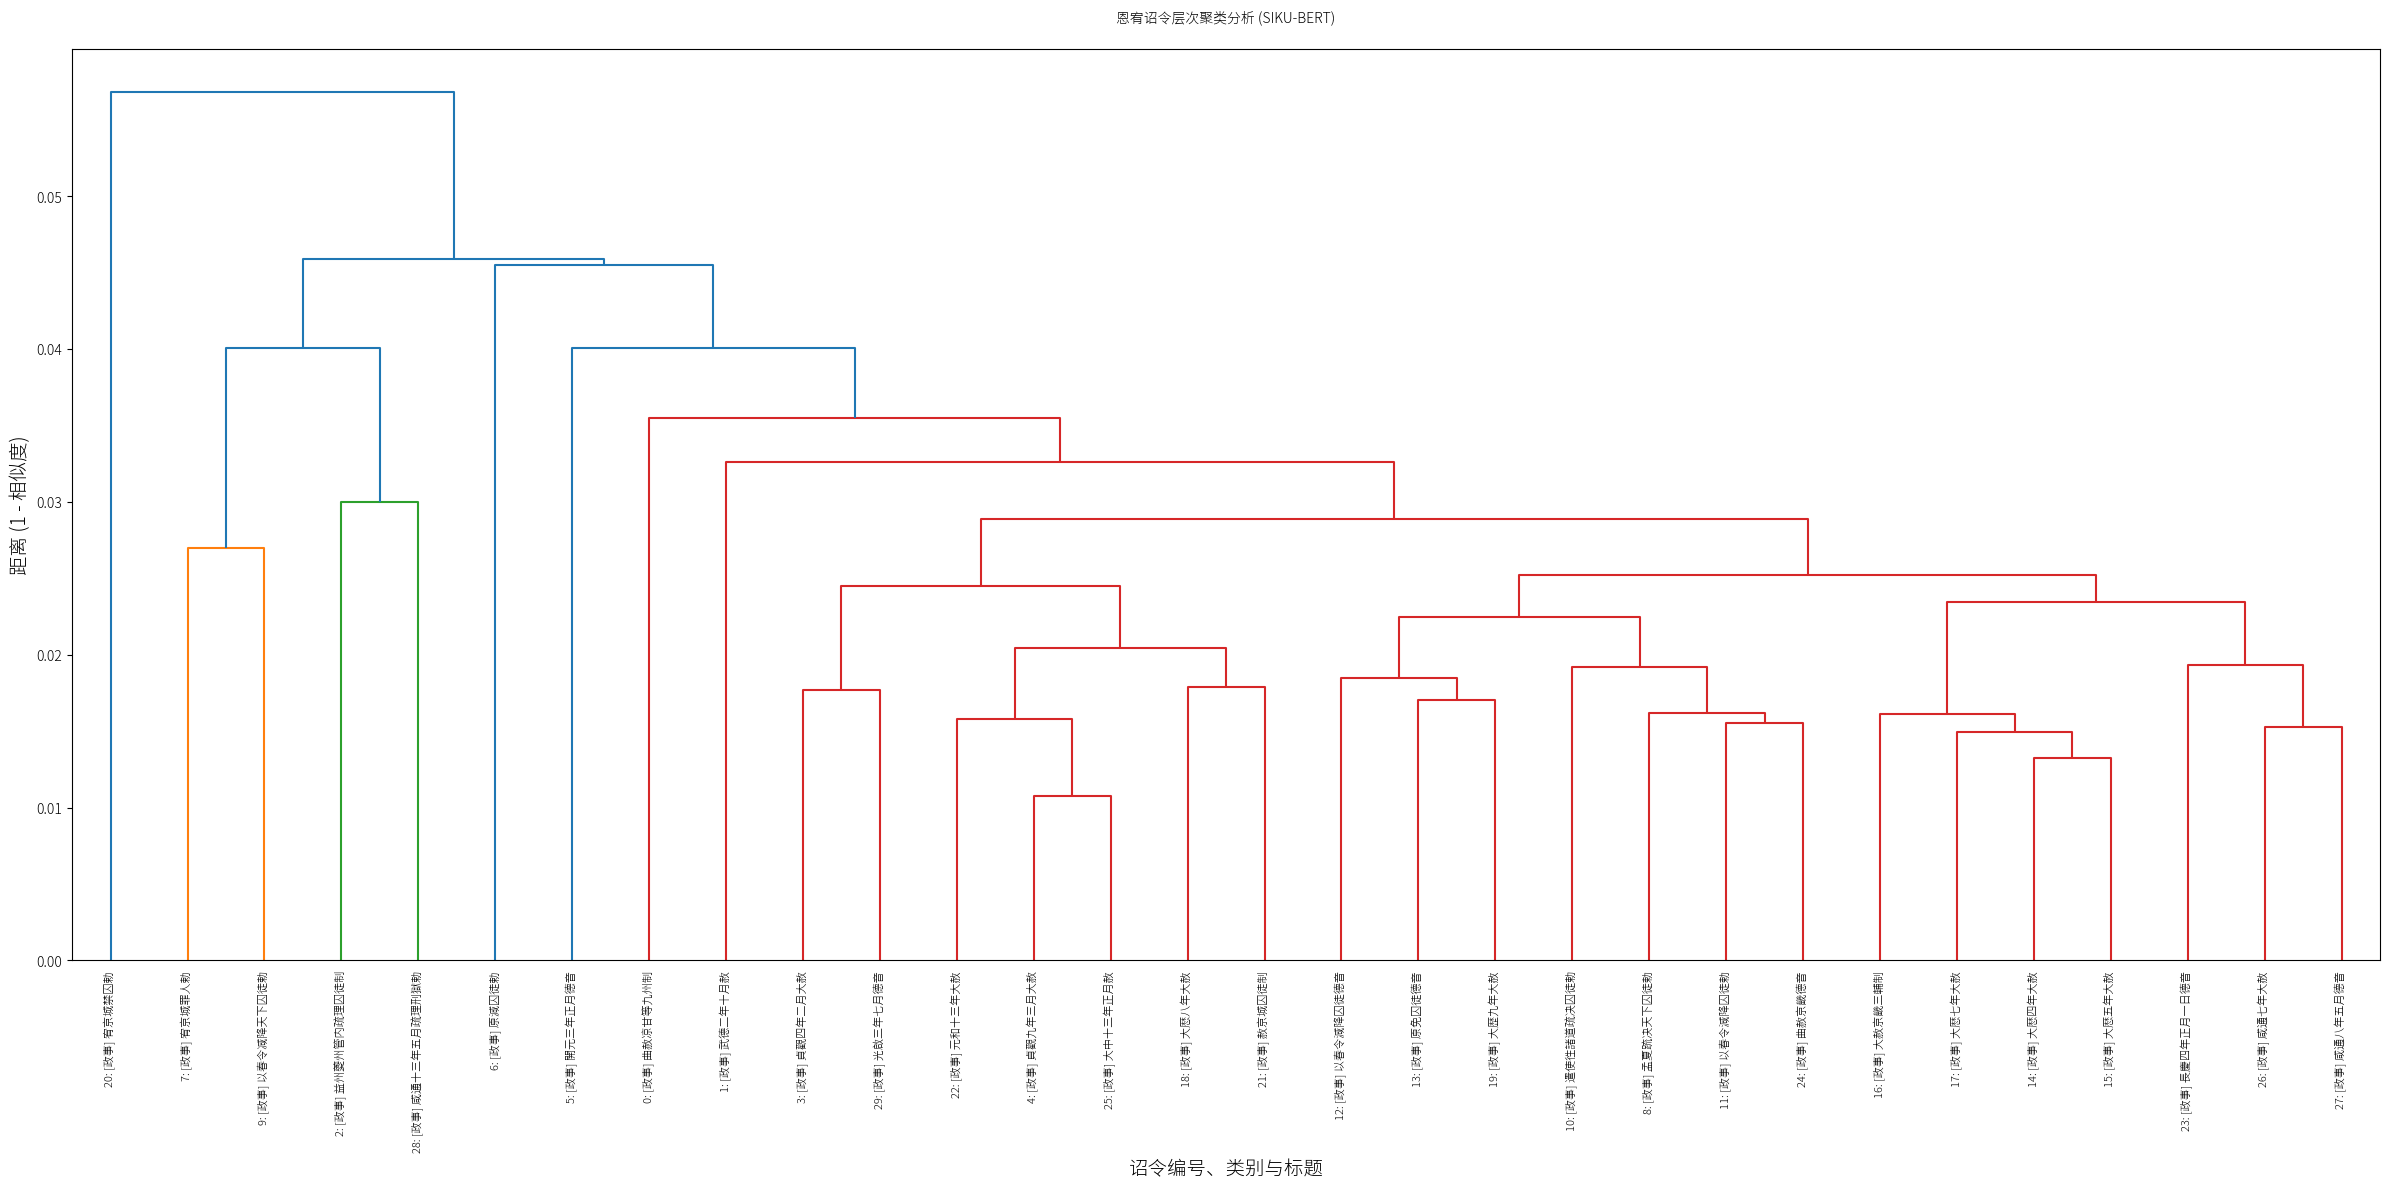

Dendrogram saved as 'dendrogram_恩宥_sikubert.png'

Edict index mapping saved to 'edict_index_mapping_恩宥.csv'

Edict Index to Title Mapping:
0: [政事] 曲赦凉甘等九州制
1: [政事] 武德二年十月赦
2: [政事] 益州夔州管内疏理囚徒制
3: [政事] 貞觀四年二月大赦
4: [政事] 貞觀九年三月大赦
5: [政事] 開元三年正月德音
6: [政事] 原減囚徒勅
7: [政事] 宥京城罪人勅
8: [政事] 孟夏䟽决天下囚徒勅
9: [政事] 以春令减降天下囚徒勅
10: [政事] 遣使徃諸道疏决囚徒勅
11: [政事] 以春令減降囚徒勅
12: [政事] 以春令減降囚徒德音
13: [政事] 原免囚徒德音
14: [政事] 大厯四年大赦
15: [政事] 大厯五年大赦
16: [政事] 大赦京畿三輔制
17: [政事] 大厯七年大赦
18: [政事] 大厯八年大赦
19: [政事] 大歴九年大赦
20: [政事] 宥京城禁囚勅
21: [政事] 赦京城囚徒制
22: [政事] 元和十三年大赦
23: [政事] 長慶四年正月一日德音
24: [政事] 曲赦京畿德音
25: [政事] 大中十三年正月赦
26: [政事] 咸通七年大赦
27: [政事] 咸通八年五月德音
28: [政事] 咸通十三年五月疏理刑獄勅
29: [政事] 光啟三年七月德音


In [15]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Font was already configured in section 1, just verify it's available
print("Using configured Chinese font for dendrogram...")
try:
    current_font = plt.rcParams['font.sans-serif'][0]
    print(f"✓ Current font: {current_font}")
    selected_font = current_font
except:
    # Fallback if font wasn't configured
    selected_font = 'DejaVu Sans'
    print("⚠ Using fallback font: DejaVu Sans")

# Convert similarity to distance
distance_matrix = 1 - similarity_matrix

# Ensure the matrix is symmetric and diagonal is zero
distance_matrix = (distance_matrix + distance_matrix.T) / 2
np.fill_diagonal(distance_matrix, 0)

# Convert the square distance matrix to condensed form (upper triangle)
# scipy's linkage expects a condensed distance matrix
condensed_distance = squareform(distance_matrix, checks=False)

# Perform hierarchical clustering
print("Performing hierarchical clustering...")
linkage_matrix = linkage(condensed_distance, method='average')

# Create labels from edict titles and social categories
# Truncate long titles and add index for clarity
labels = []
for i in range(len(df_d_type)):
    title = df_d_type.iloc[i]['text_title'] if 'text_title' in df_d_type.columns else f"Edict {i}"
    social_cat = df_d_type.iloc[i]['social_category'] if 'social_category' in df_d_type.columns else ''
    
    # Truncate title if too long
    if len(title) > 15:
        title = title[:15] + '...'
    
    # Combine index, social category, and title
    if social_cat:
        labels.append(f"{i}: [{social_cat}] {title}")
    else:
        labels.append(f"{i}: {title}")

# Plot dendrogram with Chinese character support
plt.figure(figsize=(24, 12))
dendrogram(
    linkage_matrix, 
    labels=labels, 
    leaf_font_size=8,
    leaf_rotation=90,  # Rotate labels vertically for better readability
    color_threshold=0.7 * max(linkage_matrix[:, 2])  # Color threshold for visual grouping
)
plt.title(f'{DOCUMENT_TYPE}诏令层次聚类分析 (SIKU-BERT)', fontsize=18, pad=20, 
         fontproperties=fm.FontProperties(family=selected_font))
plt.xlabel('诏令编号、类别与标题', fontsize=14, 
          fontproperties=fm.FontProperties(family=selected_font))
plt.ylabel('距离 (1 - 相似度)', fontsize=14, 
          fontproperties=fm.FontProperties(family=selected_font))
plt.tight_layout()
plt.savefig(f'dendrogram_{DOCUMENT_TYPE}_sikubert.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Dendrogram saved as 'dendrogram_{DOCUMENT_TYPE}_sikubert.png'")

# Save the mapping table to a CSV file for easy reference
mapping_df = pd.DataFrame({
    'Index': range(len(df_d_type)),
    'Social_Category': [df_d_type.iloc[i]['social_category'] if 'social_category' in df_d_type.columns 
                        else '' for i in range(len(df_d_type))],
    'Title': [df_d_type.iloc[i]['text_title'] if 'text_title' in df_d_type.columns 
              else f"Edict {i}" for i in range(len(df_d_type))],
    'Text_Preview': [df_d_type.iloc[i]['text_contents_punctuated'][:100] + '...' 
                     for i in range(len(df_d_type))]
})

mapping_df.to_csv(f'edict_index_mapping_{DOCUMENT_TYPE}.csv', index=False, encoding='utf-8')
print(f"\nEdict index mapping saved to 'edict_index_mapping_{DOCUMENT_TYPE}.csv'")

# Also print the mapping table
print("\n" + "="*100)
print("Edict Index to Title Mapping:")
print("="*100)
for i in range(len(df_d_type)):
    title = df_d_type.iloc[i]['text_title'] if 'text_title' in df_d_type.columns else f"Edict {i}"
    social_cat = df_d_type.iloc[i]['social_category'] if 'social_category' in df_d_type.columns else ''
    if social_cat:
        print(f"{i}: [{social_cat}] {title}")
    else:
        print(f"{i}: {title}")

## Summary

This notebook has successfully:
1. Loaded and filtered edicts of the selected document type from the dataset
2. Generated semantic embeddings using SIKU-BERT (specialized for Classical Chinese)
3. Calculated pairwise cosine similarity between all edicts
4. Visualized the similarity patterns through heatmaps and distributions
5. Identified the most similar edicts for content comparison
6. Performed clustering analysis to identify groups of related documents

The use of SIKU-BERT provides embeddings specifically trained on Classical Chinese texts, which should better capture the semantic relationships in the edicts compared to general-purpose multilingual models.

All embeddings and similarity matrices have been saved for future analysis. To analyze a different document type, simply change the `DOCUMENT_TYPE` variable in section 4b and re-run the subsequent cells.